# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?

In [75]:
from collections import deque
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm

import torch
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt
torch.manual_seed(42)

import os
import random
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

In [91]:
# VTXS numbers here are inclusive
MIN_VTXS = 3 # 3
MAX_VTXS = 3 # 8
MAX_TUNE_VTXS = 3 # 15
AVG_DEG = 2
SEQ_LEN = MAX_VTXS * AVG_DEG + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [76]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * (n-1))]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [u,v]
            adjacencies[u].add(v)
            adjacencies[v].add(u)

    edge_list += [PAD_TOKEN]*(SEQ_LEN-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(n, G, target=2):
    dist = [n for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(n, adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1, device=device)
    labels = torch.tensor(distance1, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

def vertices_on_shortest_12_path(n, G, target=2):
    dist = [n for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(n, adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs, device=device)
    labels = torch.tensor(distance, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [86]:
mkbatch(5)

(tensor([[4, 3, 2, 3, 1, 2, 0, 0, 2],
         [3, 4, 3, 1, 2, 3, 0, 0, 2],
         [4, 2, 3, 2, 0, 0, 0, 0, 2],
         [3, 4, 4, 3, 0, 0, 0, 0, 2],
         [1, 2, 2, 4, 0, 0, 0, 0, 2]], device='cuda:0'),
 tensor([1., 2., 4., 4., 1.], device='cuda:0', dtype=torch.bfloat16),
 tensor([[False, False, False, False, False, False,  True,  True, False],
         [False, False, False, False, False, False,  True,  True, False],
         [False, False, False, False,  True,  True,  True,  True, False],
         [False, False, False, False,  True,  True,  True,  True, False],
         [False, False, False, False,  True,  True,  True,  True, False]],
        device='cuda:0'))

(array([ 663.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  284.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   39.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1062.]),
 array([1.      , 1.046875, 1.09375 , 1.140625, 1.1875  , 1.234375,
        1.28125 , 1.328125, 1.375   , 1.421875, 1.46875 , 1.515625,
        1.5625  , 1.609375, 1.65625 , 1.703125, 1.75    , 1.796875,
        1.84375 , 1.890625, 1.9375  , 1.984375, 2.03125 , 2.078125,
        2.125   , 2.171875, 2.21875 , 2.265625, 2.3125  , 2.359375,
        2.40625 , 2.453125, 2.5     , 2.546875, 2.59375 , 2.640625,
        2.6875  , 2.734375, 2.78125 , 2.828125, 2.875   , 2.921875,
        2.

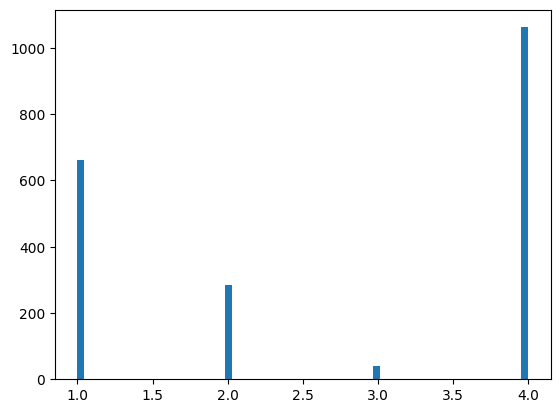

In [87]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1714.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  305.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          29.]),
 array([1.     , 1.03125, 1.0625 , 1.09375, 1.125  , 1.15625, 1.1875 ,
        1.21875, 1.25   , 1.28125, 1.3125 , 1.34375, 1.375  , 1.40625,
        1.4375 , 1.46875, 1.5    , 1.53125, 1.5625 , 1.59375, 1.625  ,
        1.65625, 1.6875 , 1.71875, 1.75   , 1.78125, 1.8125 , 1.84375,
        1.875  , 1.90625, 1.9375 , 1.96875, 2.     , 2.03125, 2.0625 ,
        2.09375, 2.125  , 2.15625, 2.1875 , 2.21875, 2.25   , 2.28125,
        2.3125 , 2.34375, 2.375  , 2.40625, 2.4375 , 2.46875

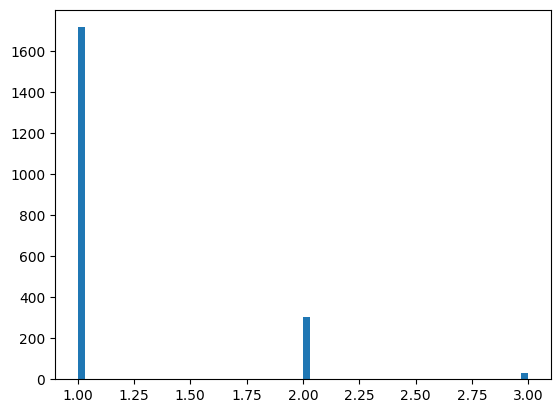

In [90]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

In [97]:
import pickle

graphs, labels, _ = mkbatch(3*10**5)

data = {
    "data": graphs,
    "labels": labels
}

with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)

# Step 2: Define Transformer Model

In [135]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, device, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, model_dim//2, dtype=torch.bfloat16)
        # seq_len is odd
        self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device, dtype=torch.bfloat16), 2, dim=1)
        # cut off last element since the target vertex is not repeated
        self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True, dtype=torch.bfloat16)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc_out = nn.Linear(model_dim*seq_len, output_dim, dtype=torch.bfloat16)

    def full_embedding(self, src):
        batch_size, src_len = src.size(0), src.size(1)
        return torch.cat((self.embedding(src) * sqrt(self.model_dim), self.fancy_encoding.repeat((batch_size, 1, 1))), dim=2)
    
    def forward(self, src, key_padding_mask):
        embed = self.full_embedding(src)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask)
        output[key_padding_mask] = 0 # Hack to stop no_grad problem
        flat_output = torch.flatten(output, start_dim=1, end_dim=2)
        output = self.fc_out(flat_output)
        return output

# Step 3: Make Model

In [136]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS # one more than the max number of vertices
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 8196 * 4 # Batch size
BPE = 32 # Batches per epoch
LR = 5e-3
WD = 2e-3
NHEADS = 1 #4
NLAYERS = 1 #16
DROPOUT = 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT, device=device).to(device)
# model = torch.compile(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*BSZ*BPE//10**6}M")
print(f"Trainable parameters in the model: {trainable_params//1000}K")

Training data: 1049M
Trainable parameters in the model: 50K


In [137]:
from torch.utils.data import DataLoader, TensorDataset

with open("data.pkl", "rb") as f:
    pickled_stuff = pickle.load(f)

data = pickled_stuff["data"].to(device)
label = pickled_stuff["labels"].to(device)
padding_mask = (data == PAD_TOKEN).bool().to(device)
dataset = TensorDataset(data, label, padding_mask)
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [.9, .1])
train_loader = DataLoader(dataset, batch_size=BSZ, shuffle=True)

# Step 4: Train the Model for the first task

In [138]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [139]:
train_err = []
test_err = []

# clear loss file
open('loss', 'w').close()

for epoch in range(NEPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
    # for batch_src, batch_labels, batch_padding_mask in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPE
        loss.backward()
        optimizer.step()

    test_loss = evaluate()
    
    test_err.append(test_loss)
    train_err.append(train_loss)
    with open('loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")
    
    if epoch % 100 == 99:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 1/1000 	 Train Err: 0.5381 	 Test Err: 0.1865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.75it/s]


Epoch 2/1000 	 Train Err: 0.1227 	 Test Err: 0.1128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 3/1000 	 Train Err: 0.1071 	 Test Err: 0.1118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 4/1000 	 Train Err: 0.1008 	 Test Err: 0.1035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.75it/s]


Epoch 5/1000 	 Train Err: 0.0972 	 Test Err: 0.1021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 6/1000 	 Train Err: 0.0949 	 Test Err: 0.0981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.76it/s]


Epoch 7/1000 	 Train Err: 0.0929 	 Test Err: 0.1021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 8/1000 	 Train Err: 0.0908 	 Test Err: 0.0977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 9/1000 	 Train Err: 0.0886 	 Test Err: 0.0952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.72it/s]


Epoch 10/1000 	 Train Err: 0.0910 	 Test Err: 0.0962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 11/1000 	 Train Err: 0.0851 	 Test Err: 0.0898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 12/1000 	 Train Err: 0.0849 	 Test Err: 0.0864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.74it/s]


Epoch 13/1000 	 Train Err: 0.0795 	 Test Err: 0.0684


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 14/1000 	 Train Err: 0.0691 	 Test Err: 0.0293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.74it/s]


Epoch 15/1000 	 Train Err: 0.0455 	 Test Err: 0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 16/1000 	 Train Err: 0.0421 	 Test Err: 0.0210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 17/1000 	 Train Err: 0.0817 	 Test Err: 0.0505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.75it/s]


Epoch 18/1000 	 Train Err: 0.0456 	 Test Err: 0.0176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 19/1000 	 Train Err: 0.0370 	 Test Err: 0.0165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 20/1000 	 Train Err: 0.0374 	 Test Err: 0.0205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.73it/s]


Epoch 21/1000 	 Train Err: 0.0372 	 Test Err: 0.0142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 22/1000 	 Train Err: 0.0343 	 Test Err: 0.0132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.75it/s]


Epoch 23/1000 	 Train Err: 0.0337 	 Test Err: 0.0119


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 24/1000 	 Train Err: 0.0713 	 Test Err: 0.0259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch 25/1000 	 Train Err: 0.0522 	 Test Err: 0.0143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.75it/s]


Epoch 26/1000 	 Train Err: 0.0342 	 Test Err: 0.0117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 27/1000 	 Train Err: 0.0864 	 Test Err: 0.0728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch 28/1000 	 Train Err: 0.0701 	 Test Err: 0.0510


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.72it/s]


Epoch 29/1000 	 Train Err: 0.0598 	 Test Err: 0.0369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 30/1000 	 Train Err: 0.0462 	 Test Err: 0.0231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.73it/s]


Epoch 31/1000 	 Train Err: 0.0387 	 Test Err: 0.0181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 32/1000 	 Train Err: 0.0351 	 Test Err: 0.0142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch 33/1000 	 Train Err: 0.0337 	 Test Err: 0.0123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.74it/s]


Epoch 34/1000 	 Train Err: 0.0331 	 Test Err: 0.0117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 35/1000 	 Train Err: 0.0329 	 Test Err: 0.0119


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 36/1000 	 Train Err: 0.0327 	 Test Err: 0.0109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.74it/s]


Epoch 37/1000 	 Train Err: 0.0319 	 Test Err: 0.0101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 38/1000 	 Train Err: 0.0317 	 Test Err: 0.0099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.71it/s]


Epoch 39/1000 	 Train Err: 0.0313 	 Test Err: 0.0095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 40/1000 	 Train Err: 0.0310 	 Test Err: 0.0097


 28%|██████████████████████████████████████████▊                                                                                                             | 9/32 [00:01<00:03,  6.50it/s]


KeyboardInterrupt: 

In [163]:
"""
Now let's figure out what it's doing. 

step 1: figure out what people are attending to 
"""

example_graph, answer, padding = mkbatch(1)
sentance_embeddings = model.full_embedding(example_graph)
Q,K,V = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

sentance_embeddings.shape, Q.shape
sentance_embeddings@Q.T

# (sentance_embeddings @ Q).shape
# sentance_embeddings.shape
# K @ sentance_embeddings

(torch.Size([1, 7, 64]), torch.Size([64, 64]))

In [34]:
plt.suptitle('MSE vs Epochs')
plt.plot(train_err, label='Train', color='blue')
plt.plot(test_err, label='Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [35]:
evaluate()

24.625

In [ ]:
batch_src, batch_labels, batch_padding_mask = next(iter(train_loader))
output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]

In [ ]:
plt.hist(output.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.hist(label.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.scatter(batch_labels.detach().cpu().numpy().flatten(),output.detach().cpu().numpy().flatten())

In [ ]:
batch_src2, batch_labels2, batch_padding_mask2 = next(iter(test_loader))
output2 = model(batch_src2, batch_padding_mask2)
loss = criterion(output2.squeeze(1), batch_labels2)
batch_src2[0], batch_labels2[0], output2[0], loss

In [ ]:
plt.scatter(batch_labels2.detach().cpu().numpy().flatten(),output2.detach().cpu().numpy().flatten())

# Step 5: Fine Tune

In [ ]:
N_TUNE_EPOCHS = 100
TUNE_LR = 0.003
TUNE_WD = 0.002

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

In [ ]:
def tuneevaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [ ]:
# This has to be in a separate cell for some weird event loop reasons
%matplotlib widget
fig,ax = plt.subplots()
fig.suptitle('MSE vs Epochs')
plt.show()
%matplotlib inline

In [13]:
tune_train_err = []
tune_test_err = []

# clear loss file
open('tune_loss', 'w').close()

for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item()/BPE
        loss.backward()
        optimizer.step()

    test_loss = tuneevaluate()
    
    tune_test_err.append(test_loss)
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    ax.plot(tune_train_err, label='Train', color='blue')
    ax.plot(tune_test_err, label='Test', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    fig.canvas.draw()
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch}.pth")

NameError: name 'N_TUNE_EPOCHS' is not defined

# Step 6: Test generalization